# Fitting QENS data

Previously, some quasi-elastic neutron scattering (QENS) data has been [simulated]() and [reduced](./../scipp/qens-reduction.ipynb), which can now be analysed with `easyCore`. 
Before the analysis can begin, it is necessary to import the experimental data and check that it looks reasonable. 
The importing of the data can be performed wiht `np.loadtxt` as the data has been stored in a simple space-separated column file.

In [1]:
import numpy as np

qens_data = np.loadtxt('./../scipp/qens_energy_transfer_known_quasi_elastic_3_pulse.dat', unpack=True)

With the data read in, we can produce a quick plot. 

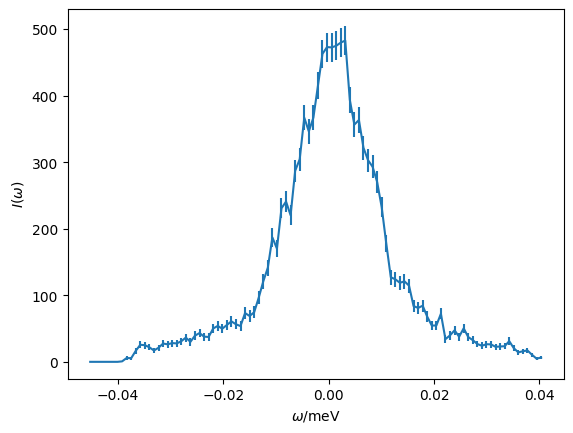

In [2]:
import matplotlib.pyplot as plt

plt.errorbar(*qens_data)
plt.xlabel('$\omega$/meV')
plt.ylabel('$I(\omega)$')
plt.show()

The QENS data covers a slightly broader range than we want to investigate, therefore we will crop the data so that we are only using that between -0.04 and 0.04 meV. 

In [3]:
q, i, di = qens_data[:, np.where((qens_data[0] > -0.04) & (qens_data[0] < 0.04))[0]]

Now that the data has been read in, we want to consider the mathematical model to be used in the analysis. 
QENS is typically analysed with by fitting a Lorentzian function to the data, which has the functional form

$$
I(\omega) = \frac{A\tau}{\pi\big[(\omega - \omega_0) ^ 2 + \tau ^ 2\big]},
$$ (lorentzian)

where $A$ is a scale factor, $\tau$ is the half-width at half maximum, and $\omega_0$ is the centre offset. 

```{admonition} Task
:class: important
Write a function that implements Eqn. {eq}`lorentzian`, called `lorentzian`. 
```

<i class="fa-solid fa-bell"></i> **Click below to show code solution**

In [4]:
def lorentzian(omega: np.ndarray) -> np.ndarray:
    """
    A Lorentzian function.
    
    :omega: the energy transfer values to calculate over.

    :return: intensity values.
    """
    return A.raw_value / np.pi * tau.raw_value / ((omega - omega_0.raw_value) ** 2 + tau.raw_value ** 2)

The Lorentzian function is then typically convolved with a Gaussian distribution that is centred at zero with some known width, $\sigma$. 
For this project, we will model $\sigma$.

In [8]:
from scipy.stats import norm

def intensity(omega):
    """
    The convolution of a Gaussian and the Lorentzian.
    
    :omega: the energy transfer values to calculate over.

    :return: intensity values.
    """
    gauss = norm(0, sigma.raw_value).pdf(omega)
    gauss /= gauss.sum()
    return np.convolve(lorentzian(omega), gauss, 'same')

This means that there is a total of four parameters in our model. 
The next step is two create `Parameter` objects for each of these parameters in the mathematical model.

```{admonition} Task
:class: important
Create four `Parameter`-type objects, for the $A$, $\tau$, $\omega_0$, and $\sigma$. 
Each should have an initial value and a uniform prior distribution, from the values given in {numref}`qens-parameters`.
```

```{list-table} Parameter values for the spherical model.
:name: qens-parameters
:header-rows: 1
:align: center

* - Parameter
  - Initial Value
  - Min
  - Max
* - $A$
  - 10
  - 1
  - 100
* - $\tau$
  - 8.0 &times; 10<sup>-3</sup>
  - 1.0 &times; 10<sup>-4</sup>
  - 1.0 &times; 10<sup>-2</sup>
* - $\omega_0$
  - 1.0 &times; 10<sup>-3</sup>
  - 0
  - 2.0 &times; 10<sup>-3</sup>
* - $\sigma$
  - 1.0 &times; 10<sup>-3</sup>
  - 1.0 &times; 10<sup>-5</sup>
  - 1.0 &times; 10<sup>-1</sup>
```

<i class="fa-solid fa-bell"></i> **Click below to show code solution**

In [18]:
from easyCore.Objects.Variable import Parameter

A = Parameter(name='A', value=10, fixed=False, min=0.01, max=100)
tau = Parameter(name='tau', value=8e-3, fixed=False, min=1e-4, max=10e-3)
omega_0 = Parameter(name='omega_0', value=0.001, fixed=False, min=0, max=0.002)
sigma = Parameter(name='sigma', value=0.001, fixed=False, min=1e-5, max=0.1)

It is now possible to compare out model, with the initial estimates to the simulated data. 

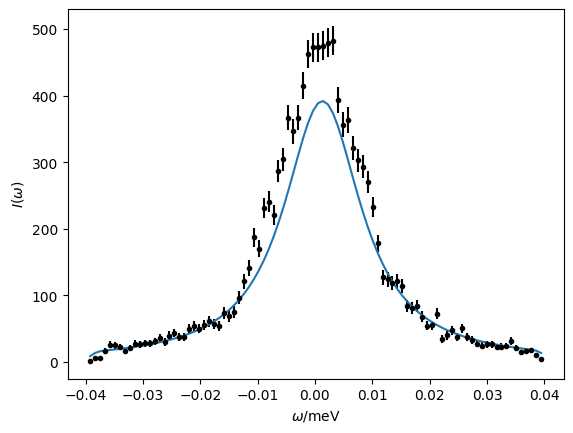

In [19]:
plt.errorbar(q, i, di, marker='.', ls='', color='k')
plt.plot(q, intensity(q), '-')
plt.xlabel('$\omega$/meV')
plt.ylabel('$I(\omega)$')
plt.show()

```{admonition} Task
:class: important
Using `easyCore` obtain maximum likelihood estimates for the four parameters of the model on comparison with the data.
```

<i class="fa-solid fa-bell"></i> **Click below to show code solution**

In [20]:
from easyCore.Objects.ObjectClasses import BaseObj
from easyCore.Fitting.Fitting import Fitter

params = BaseObj(name='params', A=A, tau=tau, omega_0=omega_0, sigma=sigma)
f = Fitter(params, intensity)

res = f.fit(x=q, y=i, weights=1/di)

We can then plot the model and the data together, as before, and print the values of the parameters, along with their uncertainties. 

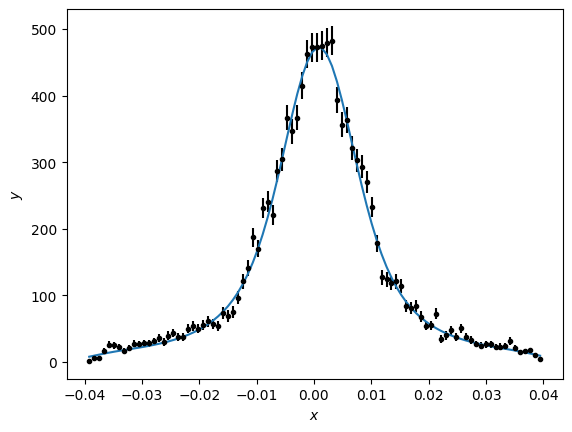

In [22]:
plt.errorbar(q, i, di, marker='.', ls='', color='k')
plt.plot(q, intensity(q), '-')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [23]:
A.value

<Measurement(11.118678716875044, 0.16957048021097534, dimensionless)>

In [24]:
tau.value

<Measurement(0.005926697624286738, 0.00027399350500017285, dimensionless)>

In [25]:
omega_0.value

<Measurement(0.0005424713732919861, 0.00014457686726591465, dimensionless)>

In [26]:
sigma.value

<Measurement(0.0036902179394917647, 0.0004087023975864533, dimensionless)>